# Training Report

This implementation contains two main Python modules: the game agent, and the neural network model. The agent contains all the code needed to train the model, and can be instantiated with specific hyperparameters. The agent utilizes a deep neural network with three fully connected layers, with activation via ReLU between layers. The agent used fixed-Q learning which learns from experiences sampled from a replay buffer. By encapsulating all the code within the agen object, multiple agents (with differing hyperparameters) can be compared.

The neural network uses linear layers (i.e., `y = Wx + b`, where the weight `W` represents regional slopes for learned features). Each linear layer is connected via the ReLU activation function, which allows for strong gradient flow during back propagation (i.e, the derivative is 1 for positive values), and "kills" weights for unimportant features (i.e., negative weights are zeroed). Backpropagation is via the PyTorch Adam optimizer with the learning rate settable on agent instantiation. For all cases in this project, a learning rate of `5e-5` was used for the optimizer. This learning rate was chosen based on previous projects in this course and brief internet searches.

Other hyperparameters that are settable for each agent include:

1. The discount rate gamma, which determines how much the next state is valued for each action. For this project, the discount rate was set to 0.99 for all training agents.
2. The learning frequency, which controls how frequently the agent enters the learning cycle from the exploration cycle. For this project, the learning frequency was set to 4 for all training agents. This means that the learning cycle runs every 4 experiences within each episode. The Agent class is implemented such that this is also the fixed-Q target update freqeuncy (i.e., the fixed-Q target is updated from the the local action value function at the end of very learning cycle).
3. The fixed-Q soft update factor $\tau$, which controls how much to value the learning update coming from the local action value function. High values of $\tau$ causes the target action value function to more closely mirror the local function and can over train the model, causing longer training runs to reach convergence or potentially never reaching convergence at all. For small values of $\tau$, learning may be too slow, which also slows down convergence to a solution. For this project, $\tau$ was varied to show the best learning/update rate. It was determined that $\tau$=0.001 was nearest to optimal for this environment and agent.

In additon to the above hyperparameters, agent instantiation can also set:

1. The environment path, which defaults to the workspaces virtual machine path `"/data/Banana_Linux_NoVis/Banana.x86_64"`.
2. The random seed (0 default), which allows for reproducible agents by setting initial random values the same on instantiation.
3. The replay buffer size, which is the size of the experience buffer from wich the fixed-Q algorithm samples from during the learning cylce. After noting that each episode completes after 300 actions are taken, this default value of 100,000 was chosen for the replay buffer size. This value is small enough that some of the first values to enter the buffer (before the agent has learned anything) leave the buffer for high episode counts. It is theorizes that this may be the only reason convergence was observed in the high- and low-tau training runs. Specifically, after 333 episodes, the initial experiences (before the agent has learning anything) are popped from the buffer. This means that as the agent continues to struggle to learn for large and small tau values, the buffer is populated with "smarter" and more valuable experiences, helping these extreme tau values to converge eventually.

In addition to the above, the agent object employs an SQLite connection to a database to store each agents training results (i.e., the average episode score for each episode). This allows for later recall and comparison as needed (see below). The agen also prints it progress in real time as it trains. This progress includes the average episode score and the percent change in the neural networks norm. Specifically, the initial norm (which can be though of as the model tensor's "length" or magnitude) is taken before each episode and after and the percent change is calculate. This give the programmer an idea of how fast the target is learning. Large changes mean the model is learning fast (perhaps too quickly) and very small changes means it is not learning very fast (or perhpas not at all).

For this exercise, I implemented five agents, all with default parameters (as described above) except for $\tau$, which was set to 0.0001, 0.001, 0.01, 0.1, and 1.0. The training results are shown in the code and resultan plot below. Specifically, it is clear that for extreme values of tau, convergence is difficult and oscillation is observed. Convergence to a solution (as defined by a moving average of the last 100 episodes greater than or equal to 13.0) is fastes for $\tau$=0.001. Note that, for this plot, the moving average starts at the fist episode, and, until 100 episodes are ran, the average is across the number of episodes played at that point. After 100 episodes, the averages is only across the last 100 episodes.

In [1]:
import agent as agent_module
from ast import literal_eval

import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


In [4]:
moving_average_tau_1e0 = literal_eval(agent_module.DB_CUR.execute("SELECT moving_averages FROM training_results WHERE tau IS 1.0").fetchone()[0])
moving_average_tau_1e1 = literal_eval(agent_module.DB_CUR.execute("SELECT moving_averages FROM training_results WHERE tau IS 0.1").fetchone()[0])
moving_average_tau_1e2 = literal_eval(agent_module.DB_CUR.execute("SELECT moving_averages FROM training_results WHERE tau IS 0.01").fetchone()[0])
moving_average_tau_1e3 = literal_eval(agent_module.DB_CUR.execute("SELECT moving_averages FROM training_results WHERE tau IS 0.001").fetchone()[0])
moving_average_tau_1e4 = literal_eval(agent_module.DB_CUR.execute("SELECT moving_averages FROM training_results WHERE tau IS 0.0001").fetchone()[0])

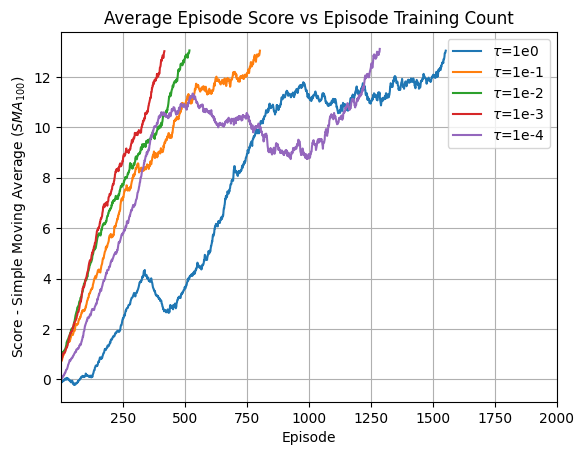

In [19]:
plt.plot([_ for _ in range(1, len(moving_average_tau_1e0) + 1)], moving_average_tau_1e0, label=r"$\tau$=1e0")
plt.plot([_ for _ in range(1, len(moving_average_tau_1e1) + 1)], moving_average_tau_1e1, label=r"$\tau$=1e-1")
plt.plot([_ for _ in range(1, len(moving_average_tau_1e2) + 1)], moving_average_tau_1e2, label=r"$\tau$=1e-2")
plt.plot([_ for _ in range(1, len(moving_average_tau_1e3) + 1)], moving_average_tau_1e3, label=r"$\tau$=1e-3")
plt.plot([_ for _ in range(1, len(moving_average_tau_1e4) + 1)], moving_average_tau_1e4, label=r"$\tau$=1e-4")
plt.title("Average Episode Score vs Episode Training Count")
plt.xlim(1, 2000)
plt.xlabel("Episode")
plt.ylabel("Score - Simple Moving Average ($SMA_{100}$)")
plt.grid()
plt.legend()
plt.show()

# Future Work

The training agent could be improved in the following ways:

1. Prioritized experience replay, in which more valuable experiences (as defined by a greater increase in the action value) are samples from the replay buffer with higher probability.
2. Dueling Q-networks, which decouple the state values from the action values. This particular environment may benefit from this model architecture because, for example, it could place a higher learning value on states where say two consecutive bananas are found one after the other. Without dueling Q-networks, only action values are learned from, and the model may learn that changing course after each banana is optimal, not accounting for sequential bananas.

I would also like to further explore varying the buffer size for extreme values of tau. As theorized above, I think that smaller buffers (within some limit) would cause these extreme values to converge faster, and this may act as a sort of prioritized replay buffer where earlier experiences (from before the agent learned very much) are discarded sooner. One way to test this would be to see if convergence time increases when the buffer is made so large that no experiences are discarded.